# Sentiment Analysis: Customer Feedback

# Notebook 4.1: Recurrent Neural Network Model + *TextVectorization*

In this notebook, customer feedback/comments/reviews are analyzed to determine whether they are positive, negative, or neutral using the Recurrent Neural Network (RNN) model.

## Setup

In [1]:
# libraries to work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# libraries for machine learning
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

C:\Users\ASUS\anaconda3\envs\hexsoftwares_ml_env\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Loading Raw Datasets

In [2]:
df1 = pd.read_csv('./datasets/a1_RestaurantReviews_HistoricDump.tsv', delimiter='\t')
df1 = df1.rename(columns={'Review': 'review_text', 'Liked': 'sentiment'})

In [3]:
df2 = pd.read_csv('./datasets/Customer_Sentiment.csv', delimiter=',')
df2 = df2[['review_text', 'sentiment']]

# function to convert sentiment labels into numeric categories
def categorize_sentiment(sentiment):
    if sentiment == "negative":
        return 0
    elif sentiment == "positive":
        return 1
    elif sentiment == "neutral":
        return 2

# apply conversion
df2.loc[:, 'sentiment'] = df2['sentiment'].apply(categorize_sentiment)

In [4]:
df_train = pd.concat([df1, df2], ignore_index=True)
df_train = df_train.dropna()
df_train

,review_text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
25895,very disappointed with the quality.,0
25896,"amazing experience, highly recommend!",1
25897,fast delivery and great packaging.,1
25898,great value for money.,1


In [5]:
df_test = pd.read_csv('./datasets/TestReviews.csv', delimiter=',')
df_test = df_test.rename(columns={'review': 'review_text', 'class': 'sentiment'})
df_test = df_test.dropna()
df_test

,review_text,sentiment
0,Fantastic spot for an even or a quite cocktail...,1
1,"Love, love, love the calamari. It's so good an...",1
2,"Love this place. Stiff martinis and cocktails,...",1
3,It's everything a great cocktail bar should be...,1
4,"I came here before a pirates game, so it was a...",1
...,...,...
4316,My wife and I caught this show at the Golden N...,0
4317,This was the dumbest show we have ever seen. ...,0
4318,My girlfriend and I went to this show. It was ...,0
4319,The restrooms looked like after an bombardment...,0


## Recurrent Neural Network: Data Splitting

The training dataset is split into features (X) and target (y). Each of these is further divided into a training set (X_train, y_train) and a validation set (X_val, y_val) to evaluate the model's generalization ability. A separate test set (X_test, y_test) is kept aside and does not need further division.

The **labels (y)** in the training, validation, and test datasets **must be integers** because 
the loss function `sparse_categorical_crossentropy` requires numeric (integer) labels for multi-class classification.

In [6]:
# features and labels for the training dataset
raw_X = df_train['review_text']  # raw text, not vectorized
y = df_train['sentiment'].values.astype(int)  # convert to integers

# split the training dataset into validation dataset
raw_X_train, raw_X_val, y_train, y_val = train_test_split(raw_X, y, test_size=0.3, random_state=42)

# features and labels for the testing dataset
raw_X_test = df_test['review_text']  # raw text, not vectorized
y_test = df_test['sentiment'].values.astype(int)  # convert to integers

# convert all features into tf.string datatype for model training # do it only after the split
raw_X_train = tf.constant(raw_X_train, dtype=tf.string)
raw_X_val = tf.constant(raw_X_val, dtype=tf.string)
raw_X_test = tf.constant(raw_X_test, dtype=tf.string)

# check the shape and data type of the datasets before and after splitting
elements = {
    "raw_X_train": raw_X_train,
    "raw_X_val": raw_X_val,
    "raw_X_test": raw_X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

for name, element in elements.items():
    print(f"{name} shape: {element.shape}")
    print(f"{name} data type: {element.dtype}\n")

raw_X_train shape: (18130,)
raw_X_train data type: <dtype: 'string'>

raw_X_val shape: (7770,)
raw_X_val data type: <dtype: 'string'>

raw_X_test shape: (4321,)
raw_X_test data type: <dtype: 'string'>

y_train shape: (18130,)
y_train data type: int64

y_val shape: (7770,)
y_val data type: int64

y_test shape: (4321,)
y_test data type: int64



After splitting the dataset, the class distributions for the training and validation datasets should be similar since they come from the same dataset. The test dataset, however, can have a different distribution as it comes from a completely separate dataset, which is acceptable in real-world scenarios.

In [7]:
# get distributions
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

# calculate totals
train_total = len(y_train)
val_total = len(y_val)
test_total = len(y_test)

# print to compare distributions with percentages
print("training dataset label distribution:")
for label, count in sorted(train_dist.items()):
    percentage = (count / train_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {train_total:,}")

print("\nvalidation dataset label distribution:")
for label, count in sorted(val_dist.items()):
    percentage = (count / val_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {val_total:,}")

print("\ntesting dataset label distribution:")
for label, count in sorted(test_dist.items()):
    percentage = (count / test_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {test_total:,}")

training dataset label distribution:
  (Class 0): 7189 (39.65%)
  (Class 1): 7356 (40.57%)
  (Class 2): 3585 (19.77%)
  Total: 18,130

validation dataset label distribution:
  (Class 0): 3152 (40.57%)
  (Class 1): 3118 (40.13%)
  (Class 2): 1500 (19.31%)
  Total: 7,770

testing dataset label distribution:
  (Class 0): 1332 (30.83%)
  (Class 1): 2989 (69.17%)
  Total: 4,321


## Recurrent Neural Network: Parameters & Hyperparameters

These values are found to be optimal within the "Notebook 3". I updated the `max_len` hyperparameter from 80 to 100 as an experiment.

In [8]:
# define parameters
MAX_LEN = 100
embedding_dim = 4
conv_filters = 4
lstm_units = 8
batch_size = 64
epochs = 30  # set higher since early stopping will prevent overfitting

## Recurrent Neural Network: Encoding with *TextVectorization*

The `TextVectorization` layer can convert words to integers and then pad or truncate sequences, all in one step.

It is adapted (trained) on the dataset using the `adapt()` method, which builds the vocabulary from the training data. Once adapted, the layer can be used to vectorize input text for model training or inference.

> Notice that in this notebook, `raw_X_train` in `adapt()` is **already a TensorFlow tensor**, converted from a pandas Series. In Notebook 3, the same line of `raw_X_train` is still a pandas Series, and only `alt_raw_X_train` is a TensorFlow tensor.
> - The input to `adapt()` <u>can</u> be a pandas Series or a TensorFlow tensor, but the input to the model, i.e., to `fit()` and `evaluate()`, <u>must</u> be a TensorFlow tensor only, <u>not</u> a pandas Series.

In [9]:
isinstance(raw_X_train, pd.Series)

False

In [10]:
isinstance(raw_X_train, tf.Tensor)

True

In [11]:
# define the tokenized layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=5000,
    output_sequence_length=MAX_LEN,
)

# adapt (equivalent to fit_on_texts())
vectorize_layer.adapt(raw_X_train)  ## tf.Tensor object is fed
vectorize_layer

<TextVectorization name=text_vectorization, built=False>

In [12]:
# compute vocabulary size and token size
vocab_size = vectorize_layer.vocabulary_size()  # returns unique words + OOV token
token_size = vocab_size + 1  # adds 1 for padding

print(f"total number of unique features/words in the training data: {vocab_size - 1}")
print(f"total number of unique features/words and the oov token in the training data: {vocab_size}")
print(f"total number of unique features/words, the padding token, and the oov token in the training data: {token_size}")

total number of unique features/words in the training data: 1607
total number of unique features/words and the oov token in the training data: 1608
total number of unique features/words, the padding token, and the oov token in the training data: 1609


## Recurrent Neural Network: Model Architecture

In [13]:
# build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),               # takes raw text, not vectorized
    vectorize_layer,                                           #
    tf.keras.layers.Embedding(token_size, embedding_dim),      # map each token to 64-dim vectors
    tf.keras.layers.Conv1D(conv_filters, kernel_size=3,        # detect local patterns/phrases
                           activation='relu'),  
    tf.keras.layers.MaxPooling1D(pool_size=2),                 # keep strongest features, reduce sequence length
    tf.keras.layers.LSTM(lstm_units, return_sequences=True,    # understand sentence-level context
                         dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.2),                              # randomly forget words to avoid memorization
    tf.keras.layers.GlobalAveragePooling1D(),                  # summarize sequence into a single vector
    tf.keras.layers.Dropout(0.2),                              # randomly forget words to avoid memorization
    tf.keras.layers.Dense(3, activation="softmax",             # output 3-class sentiment prediction
                          kernel_regularizer=tf.keras.regularizers.l2(1e-4))
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 100)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 100, 4)              │           6,436 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 98, 4)               │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 49, 4)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 49, 8)               │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 49, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,931 (27.07 KB)

 Trainable params: 6,931 (27.07 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compile the model
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy', 'sparse_categorical_accuracy']
)

# add early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # stop if no improvement for 3 epochs
    restore_best_weights=True  # restore weights from best epoch
)

## Recurrent Neural Network: Loss & Accuracy

In [15]:
# plot function
def plot_loss_and_acc(history, epochs):
    fig, axs = plt.subplots(2 , 1)
    fig.set_size_inches(18.5, 10.5)
    axs1 = axs[0]
    axs2 = axs[1]

    axs1.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
    axs1.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
    axs1.legend(loc='lower right')
    axs1.set(xlabel='Epoch', ylabel='Accuracy')
    axs1.set_title('Training and Validation Accuracy')
    axs1.grid(True)

    axs2.plot(range(epochs), history.history['loss'], label='Training Loss')
    axs2.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
    axs2.legend(loc='upper right')
    axs2.set(xlabel='Epoch', ylabel='Error')
    axs2.set_title('Training and Validation Loss')
    axs2.grid(True)
    fig.tight_layout()
    plt.show()

## Recurrent Neural Network: Model Training & Evaluation

In RNNs, training and validation happen together.

Epoch 1/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.4713 - loss: 1.0068 - sparse_categorical_accuracy: 0.4713 - val_accuracy: 0.7905 - val_loss: 0.5492 - val_sparse_categorical_accuracy: 0.7905
Epoch 2/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 52s 91ms/step - accuracy: 0.7641 - loss: 0.5244 - sparse_categorical_accuracy: 0.7641 - val_accuracy: 0.7915 - val_loss: 0.3461 - val_sparse_categorical_accuracy: 0.7915
Epoch 3/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 64s 113ms/step - accuracy: 0.8970 - loss: 0.3009 - sparse_categorical_accuracy: 0.8970 - val_accuracy: 0.9807 - val_loss: 0.1229 - val_sparse_categorical_accuracy: 0.9807
Epoch 4/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9553 - loss: 0.1877 - sparse_categorical_accuracy: 0.9553 - val_accuracy: 0.9831 - val_loss: 0.0976 - val_sparse_categorical_accuracy: 0.9831
Epoch 5/30
567/567 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.9598 - loss: 0.1733 - sparse_categorical_accuracy: 0.9598 - val_accuracy: 0.9849 - val_loss

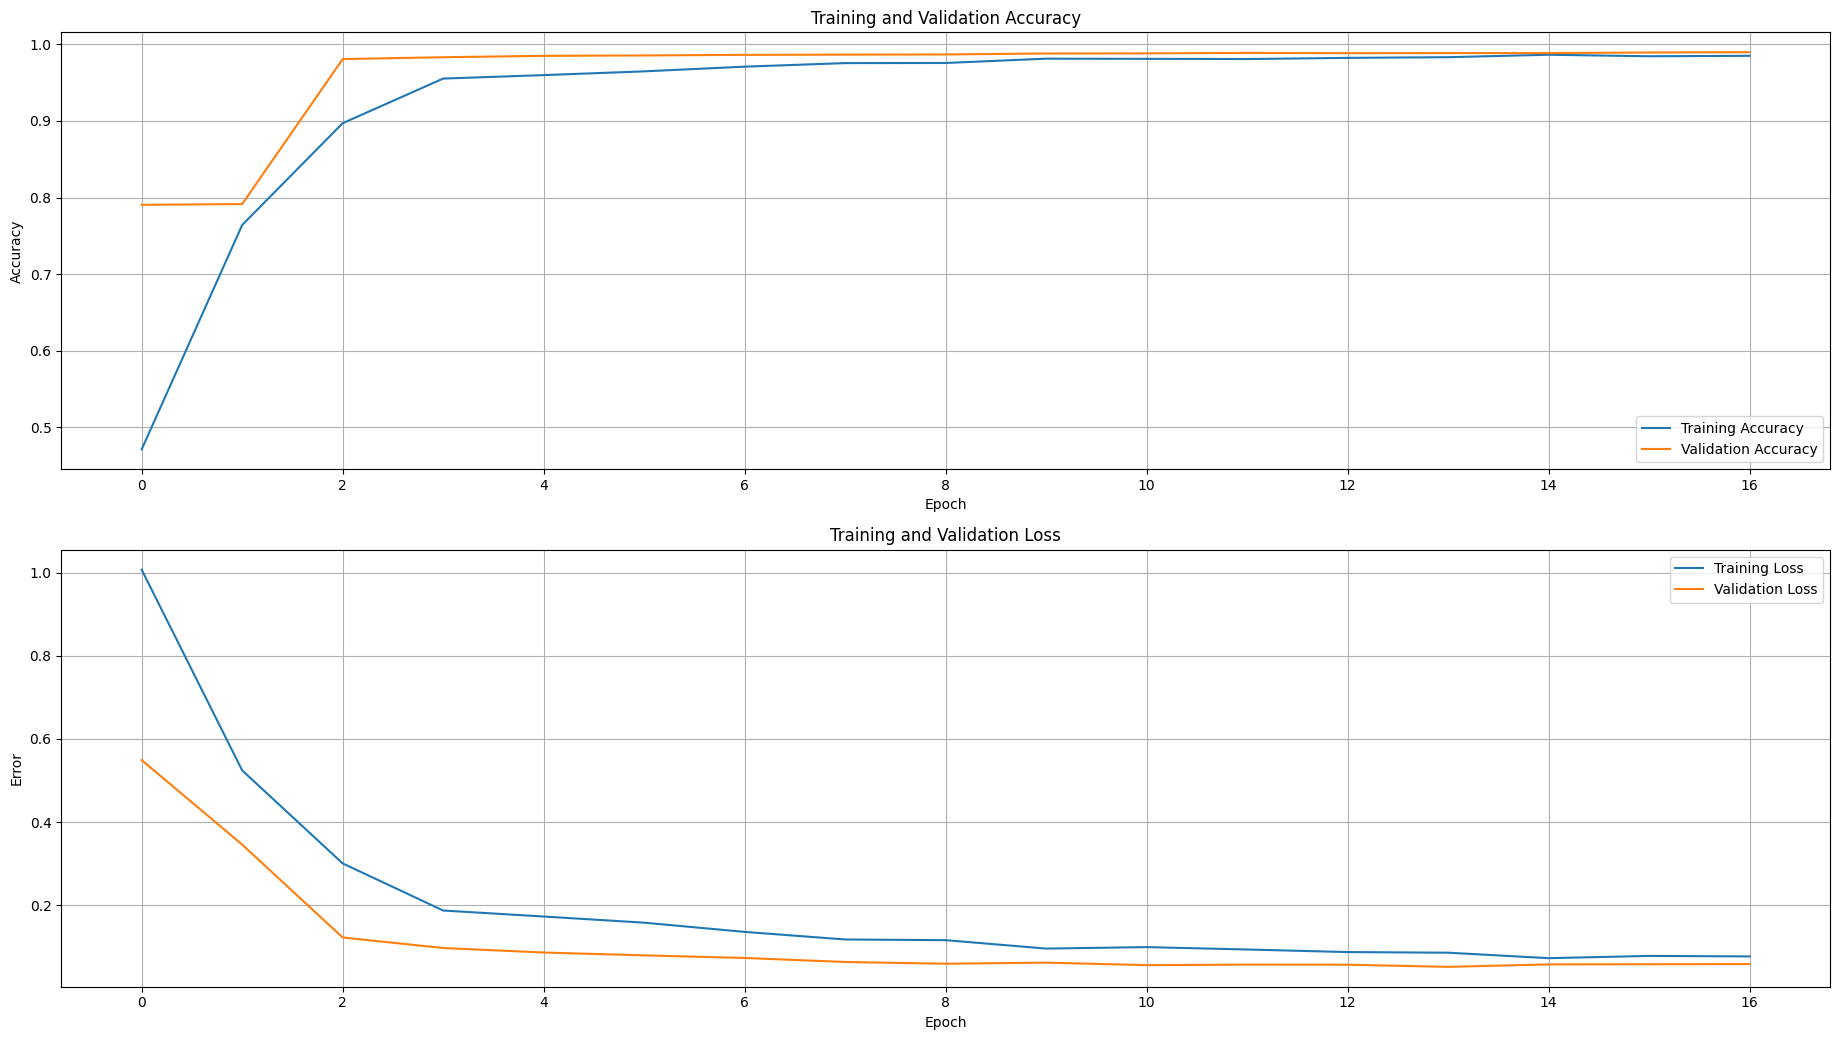

In [16]:
# train the model
history = model.fit(
    raw_X_train, y_train,  # raw text, not vectorized
    epochs=epochs, 
    validation_data=(raw_X_val, y_val),  # raw text, not vectorized
    callbacks=[early_stopping]  # add callback
)

# plot
plot_loss_and_acc(history, len(history.history['loss']))  # not all epochs may be executed

## Recurrent Neural Network: Model Testing

Since the validation dataset is used already, the model is evaluated using the testing dataset.

In [17]:
# evaluate on test data
results = model.evaluate(raw_X_test, y_test)  # raw text, not vectorized
print(f"loss on test data: {results[0]:.4f}")
print(f"accuracy on test data: {results[1]:.4f}")

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6311 - loss: 1.2424 - sparse_categorical_accuracy: 0.6311
loss on test data: 1.2424
accuracy on test data: 0.6311


## Recurrent Neural Network: Confusion Matrix

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Accuracy on test data with the best model: 0.631104
F1-macro on test data with the best model: 0.412198
class names: ['Negative', 'Positive', 'Neutral']


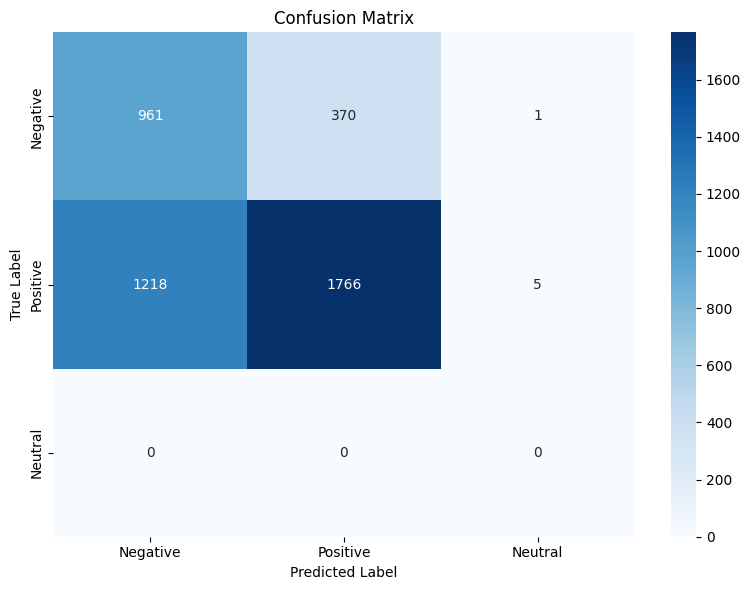

In [18]:
# make predictions using best model
y_pred_probs = model.predict(raw_X_test)

# convert probabilities to class labels
y_pred_test = np.argmax(y_pred_probs, axis=1)

# evaluate scores on testing dataset
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"Accuracy on test data with the best model: {test_accuracy:.6f}")
print(f"F1-macro on test data with the best model: {test_f1_macro:.6f}")

# compute confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

## actual labels
class_names = []

## get unique classes (integers)
classes = sorted(df_train['sentiment'].unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Negative")
    elif c == 1:
        class_names.append("Positive")
    elif c == 2:
        class_names.append("Neutral")

print(f"class names: {class_names}")

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Recurrent Neural Network: Model Testing with Any Reviews

In [19]:
review_to_predict = str(input("Enter a review: "))

def predict(review_to_predict):
    # convert to a tensor
    review_input = tf.convert_to_tensor([review_to_predict])

    # predict
    prediction_probs = model.predict(review_input, verbose=0)
    prediction_class = np.argmax(prediction_probs[0])

    print(f"\nPrediction: {class_names[prediction_class]}")
    print(f"\nProbabilities:{class_names[0]}: {prediction_probs[0][0]:.4f}, "
          f"{class_names[1]}: {prediction_probs[0][1]:.4f}, "
          f"{class_names[2]}: {prediction_probs[0][2]:.4f}")

predict(review_to_predict)

Enter a review: the delayed service is very costly

Prediction: Positive

Probabilities:Negative: 0.0037, Positive: 0.9961, Neutral: 0.0002


## Recurrent Neural Network: Saving Model

In [20]:
model.save('./models/sentiment_analysis_rnn_textvectorization_model.keras')

This notebook is done by `La Wun Nannda`.